In [86]:
import pandas as pd
import numpy as np
import os, random, cv2, shutil, platform, sys

import keras
import keras.backend as k
from keras.layers import Conv2D,MaxPooling2D,SpatialDropout2D,Flatten,Dropout,Dense
from keras.models import Sequential,load_model
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from PIL import Image

### BG Remover

In [5]:
folderNames = ["Arjun","Guava","Jamun","Lemon","Mango","Pomegranate"]

inpFolder = r"E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\dataset"
outFolder = r"E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\bgRemoved_dataset"
for folder in folderNames:
    for filename in os.listdir(os.path.join(inpFolder,folder)):
        if filename.endswith(".JPG"):
            img =  cv2.imread(os.path.join(inpFolder,folder,filename))
            hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
            
            # find the green color in the leaf
            mask_green = cv2.inRange(hsv, (36,39,20), (86,255,255))
            # find the brown color1
            mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
            # find the yellow color in the leaf
            mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))

            # find any of the three colors(green or brown or yellow) in the image
            mask = cv2.bitwise_or(mask_green, mask_brown)
            mask = cv2.bitwise_or(mask, mask_yellow)

            # Bitwise-AND mask and original image
            res = cv2.bitwise_and(img,img, mask= mask)
            cv2.imwrite(os.path.join(outFolder,folder,filename), res)    
    print(folder," had been completed!")


Arjun  had been completed!
Guava  had been completed!
Jamun  had been completed!
Lemon  had been completed!
Mango  had been completed!
Pomegranate  had been completed!


### Normalizing the dataset

In [17]:
folderNames = ["Arjun","Guava","Jamun","Lemon","Mango","Pomegranate"]

inpFolder = r"E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\bgRemoved_dataset"

for folder in folderNames:
    foldername = os.path.join(inpFolder,folder)
    for filename in os.listdir(foldername):
        if filename.endswith(".JPG"):
            f_img = foldername+"/"+filename
            img = Image.open(f_img)
            img = img.resize((600,400))
            img.save(f_img)
    print(folder,"has been normalized!")

### Split data into train, test

In [18]:
rootdir= "E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\bgRemoved_dataset"
destdir= "E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\final_dataset" 
classes = ["Arjun","Guava","Jamun","Lemon","Mango","Pomegranate"]
for i in classes:
    os.makedirs(destdir +'/train/' + i)
    os.makedirs(destdir +'/test/' + i)
    source = rootdir + '/' + i
    allFileNames = os.listdir(source)
    np.random.shuffle(allFileNames)
    test_ratio = 0.4
    train_FileNames, test_FileNames = np.split(np.array(allFileNames),[int(len(allFileNames)* (1 - test_ratio))])
    train_FileNames = [source+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [source+'/' + name for name in test_FileNames.tolist()]
    for name in train_FileNames:
      shutil.copy(name, destdir +'/train/' + i)
    for name in test_FileNames:
      shutil.copy(name, destdir +'/test/' + i)

### CNN

In [89]:

model=Sequential()


model.add(Conv2D(filters=48,kernel_size=3,activation='relu',input_shape=(600,400,3)))

model.add(MaxPooling2D(pool_size=2,strides=2))

model.add(Conv2D(filters=48,kernel_size=3,activation='relu'))

model.add(MaxPooling2D(pool_size=2,strides=2))

model.add(Conv2D(filters=32,kernel_size=3,activation='relu'))

model.add(MaxPooling2D(pool_size=2,strides=2))

model.add(Flatten())

model.add(Dense(128,activation='relu'))

model.add(Dense(64,activation='relu'))

model.add(Dense(4,activation='softmax'))

model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

model.summary()

from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(
        'E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\final_dataset\\train',
        target_size=(600,400),
        batch_size=32,  
        class_mode='categorical')

test_set = test_datagen.flow_from_directory(
        'E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\final_dataset\\test',
        target_size=(600,400),
        batch_size=32,  
        class_mode='categorical')

model_saved=model.fit_generator(
        generator=training_set,
        epochs=10,
        validation_data=test_set)

model.save('newmodel.h5',model_saved)




Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 598, 398, 48)      1344      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 299, 199, 48)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 297, 197, 48)      20784     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 148, 98, 48)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 146, 96, 32)       13856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 73, 48, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 112128)           

In [90]:
#To test for individual images

test_image=image.load_img('E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\final_dataset\\train\\Arjun\\0002_0123.JPG',target_size=(600,400,3))

test_image
test_image=image.img_to_array(test_image)
test_image=np.expand_dims(test_image,axis=0)
a=model.predict(test_image)
print(a)


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\final_dataset\\train\\Arjun\\0002_0123.JPG'

### temp

In [71]:
from skimage.io import imshow, imread
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.morphology import closing
from skimage.measure import label, regionprops, regionprops_table
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
import os

In [74]:
folderNames = ["Arjun","Guava","Jamun","Lemon","Mango","Pomegranate"]
inpFolder = "E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\final_dataset\\train"


for folder in folderNames:
    foldername = os.path.join(inpFolder,folder)
    table = pd.DataFrame()
    for filename in os.listdir(foldername):
        if filename.endswith(".JPG"):
            f_img = os.path.join(foldername,filename)
            image = rgb2gray(imread(f_img))
            binary = image < threshold_otsu(image)
            binary = closing(binary)
            label_img = label(binary)
            tempDict = regionprops_table(label_img, image,['convex_area', 'area','eccentricity', 'extent','inertia_tensor','major_axis_length','minor_axis_length'])
            tempDict['convex_ratio'] = tempDict['area']/tempDict['convex_area']
            tempDict['label'] = filename
            table = table.append(tempDict, ignore_index = True)
    table.to_csv(os.path.join("E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\features","train",folder+".csv"))


In [85]:
folderNames = ["Arjun","Guava","Jamun","Lemon","Mango","Pomegranate"]
inpFolder = "E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\final_dataset\\train"


for folder in folderNames:
    foldername = os.path.join(inpFolder,folder)
    df = pd.DataFrame()
    for filename in os.listdir(foldername):
        if filename.endswith(".JPG"):
            f_img = os.path.join(foldername,filename)
            image = rgb2gray(imread(f_img))
            binary = image < threshold_otsu(image)
            binary = closing(binary)
            label_img = label(binary)
            
            
            table = pd.DataFrame(regionprops_table(label_img, image,['convex_area', 'area', 'eccentricity','extent', 'inertia_tensor','major_axis_length', 'minor_axis_length','perimeter', 'solidity', 'image','orientation', 'moments_central','moments_hu', 'euler_number','equivalent_diameter','mean_intensity', 'bbox']))
            table['perimeter_area_ratio'] = table['perimeter']/table['area']
            real_images = []
            std = []
            mean = []
            percent25 = []
            percent75 = []
            for prop in regionprops(label_img): 
                min_row, min_col, max_row, max_col = prop.bbox
                img = image[min_row:max_row,min_col:max_col]
                real_images += [img]
                mean += [np.mean(img)]
                std += [np.std(img)]
                percent25 += [np.percentile(img, 25)] 
                percent75 += [np.percentile(img, 75)]
            table['real_images'] = real_images
            table['mean_intensity'] = mean
            table['std_intensity'] = std
            table['25th Percentile'] = mean
            table['75th Percentile'] = std
            table['iqr'] = table['75th Percentile'] - table['25th Percentile']
            table['label'] = filename
            df = pd.concat([df, table], axis=0)
    df.to_csv(os.path.join("E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\features","train",folder+".csv"))


In [76]:
folderNames = ["Arjun","Guava","Jamun","Lemon","Mango","Pomegranate"]
inpFolder = "E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\final_dataset\\test"


for folder in folderNames:
    foldername = os.path.join(inpFolder,folder)
    table = pd.DataFrame()
    for filename in os.listdir(foldername):
        if filename.endswith(".JPG"):
            f_img = os.path.join(foldername,filename)
            image = rgb2gray(imread(f_img))
            binary = image < threshold_otsu(image)
            binary = closing(binary)
            label_img = label(binary)
            tempDict = regionprops_table(label_img, image,['convex_area', 'area','eccentricity', 'extent','inertia_tensor','major_axis_length','minor_axis_length'])
            tempDict['convex_ratio'] = tempDict['area']/tempDict['convex_area']
            tempDict['label'] = filename
            table = table.append(tempDict, ignore_index = True)
    table.to_csv(os.path.join("E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\features","test",folder+".csv"))


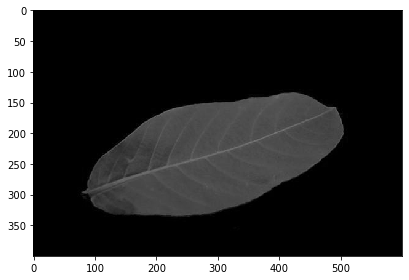

In [77]:
# get the filenames of the leaves under the directory “Leaves”
image_path_list = os.listdir("E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\final_dataset\\train\\Arjun")
 # looking at the first image
i = 0
image_path = image_path_list[i]
image = rgb2gray(imread("E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\final_dataset\\train\\Arjun\\"+image_path))
imshow(image)

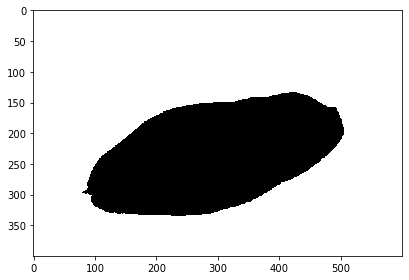

In [78]:
binary = image < threshold_otsu(image)
binary = closing(binary)
imshow(binary)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\io\_plugins\matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


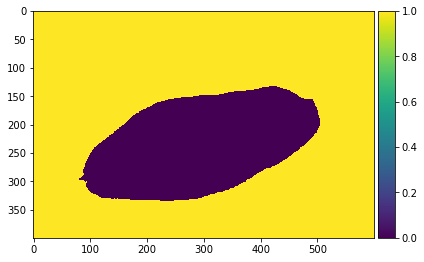

In [79]:
label_img = label(binary)
imshow(label_img)

In [80]:
table = pd.DataFrame(regionprops_table(label_img, image,
                                       ['convex_area', 'area',
                                        'eccentricity', 'extent',                   
                                        'inertia_tensor',
                                        'major_axis_length', 
                                        'minor_axis_length']))
table['convex_ratio'] = table['area']/table['convex_area']
table['label'] = image_path[5]
table

,convex_area,area,eccentricity,extent,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,major_axis_length,minor_axis_length,convex_ratio,label
0,240000,182012,0.743153,0.758383,36098.147781,-860.150488,-860.150488,16215.74136,760.371384,508.780487,0.758383,0


In [83]:
table

,convex_area,area,eccentricity,extent,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,major_axis_length,minor_axis_length,convex_ratio,label
0,240000,182012,0.743153,0.758383,36098.147781,-860.150488,-860.150488,16215.74136,760.371384,508.780487,0.758383,0


In [60]:
table = pd.DataFrame(regionprops_table(label_img, image,
                                       ['convex_area', 'area',
                                        'eccentricity', 'extent',                   
                                        'inertia_tensor',
                                        'major_axis_length', 
                                        'minor_axis_length']))
table['convex_ratio'] = table['area']/table['convex_area']
table['label'] = image_path[5]
table

,convex_area,area,eccentricity,extent,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,major_axis_length,minor_axis_length,convex_ratio,label
0,240000,182012,0.743153,0.758383,36098.147781,-860.150488,-860.150488,16215.74136,760.371384,508.780487,0.758383,0


In [68]:
d = regionprops_table(label_img, image,
                                       ['convex_area', 'area',
                                        'eccentricity', 'extent',                   
                                        'inertia_tensor',
                                        'major_axis_length', 
                                        'minor_axis_length'])

In [69]:
d

{'convex_area': array([240000]),
 'area': array([182012]),
 'eccentricity': array([0.74315344]),
 'extent': array([0.75838333]),
 'inertia_tensor-0-0': array([36098.14778073]),
 'inertia_tensor-0-1': array([-860.1504884]),
 'inertia_tensor-1-0': array([-860.1504884]),
 'inertia_tensor-1-1': array([16215.7413601]),
 'major_axis_length': array([760.37138432]),
 'minor_axis_length': array([508.7804872])}

In [75]:
abc = pd.read_csv("E:\\amrita class notes\\Final year project\\Sem 7\\Dataset\\features\\train\\Arjun.csv")
abc.head()

,Unnamed: 0,area,convex_area,convex_ratio,eccentricity,extent,inertia_tensor-0-0,inertia_tensor-0-1,inertia_tensor-1-0,inertia_tensor-1-1,label,major_axis_length,minor_axis_length
0,0,[182012],[240000],[0.75838333],[0.74315344],[0.75838333],[36098.14778073],[-860.1504884],[-860.1504884],[16215.7413601],0002_0003.JPG,[760.37138432],[508.7804872]
1,1,[218451],[240000],[0.9102125],[0.74713435],[0.9102125],[32469.63079355],[-218.10912798],[-218.10912798],[14348.5509852],0002_0009.JPG,[720.80239312],[479.09792165]
2,2,[210542],[240000],[0.87725833],[0.74669035],[0.87725833],[33435.25573006],[-105.29804578],[-105.29804578],[14794.40462418],0002_0010.JPG,[731.41890067],[486.51922614]
3,3,[221046 3 1],[240000 3 1],[0.921025 1. 1. ],[0.74472211 1. 0. ],[0.921025 1. 1. ],[3.20652622e+04 6.66666667e-01 0.00000000e+00],[-146.81013385 -0. -0. ],[-146.81013385 -0. -0. ],[14283.26610473 0. 0. ],0002_0012.JPG,[716.28457091 3.26598632 0. ],[478.0301933 0. 0. ]
4,4,[214891],[240000],[0.89537917],[0.74820902],[0.89537917],[32849.71925213],[-259.08013109],[-259.08013109],[14465.15370412],0002_0016.JPG,[725.01993962],[481.02396454]
